In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from scipy.stats import randint
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')

In [3]:
def annotate_bars_horizontal(ax, cat_count):
    """Annotates bar plots with percentages.
    For horizontally oriented bar plots.
    """
    height = [p.get_width() for p in ax.patches]
    patch = [p for p in ax.patches]
    total = sum(height)
    for i in range(cat_count):
        pp = patch[i]
        hh = height[i]
        # Get individual hue bar percentage
        percentage = '{:.1f}%'.format(100 * hh/total)
        # Get x,y location for annotate
        x = pp.get_x() + pp.get_width()
        y = pp.get_y() + pp.get_height() / 2.0
        ax.annotate(percentage, (x, y), size = 12)

def annotate_bars_horizontal_hue(ax, cat_count, hue_count):
    """Annotates bar plots with percentages.
    Hue group percentages sum to 100%.
    For horizontally oriented bar plots.
    """
    height = [p.get_width() for p in ax.patches]
    patch = [p for p in ax.patches]
    
    # First loop to get total height in a hue group
    totals = list()
    for i in range(cat_count):
        sum = 0
        for j in range(hue_count):
            loc = j*cat_count + i
            sum += height[loc]
        totals.append(sum)
    
    # Second loop over all bars
    # Loop over hue groups i.e. the categories
    for i in range(cat_count):
        # Loop over bars in hue groups
        for j in range(hue_count):
            loc = j*cat_count + i
            pp = patch[loc]
            hh = height[loc]
            # Get individual hue bar percentage
            percentage = '{:.1f}%'.format(100 * hh/totals[i])
            # Get x,y location for annotate
            x = pp.get_x() + pp.get_width()
            y = pp.get_y() + pp.get_height() / 2.0
            ax.annotate(percentage, (x, y), size = 12)
            
def label_encode(df, feats):
    """Label encode the dataframe for specified features."""
    le = LabelEncoder()
    dff = df[feats].apply(LabelEncoder().fit_transform)
    df[feats] = dff[feats]
    return df

def one_hot_encode(df, feats):
    """One hot encode the dataframe for specified features."""
    dff = pd.get_dummies(df[feats]).astype(int)
    return df.drop(feats, axis=1).join(dff)

def scale_data(df, feats):
    """Scale specified features in the dataframe."""
    scaler = RobustScaler()
    dff = pd.DataFrame()
    dff[feats] = scaler.fit_transform(df[feats])
    return df.drop(feats, axis=1).join(dff)

In [4]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- Upon initial inspection, the CustomerId column might appear to serve as a distinct identifier for each customer. 
- However, closer examination reveals that it is not truly unique. For instance, the CustomerId 15682355 is linked to multiple surnames, indicating that it is not a conventional joint account.
- Therefore, it is advisable to eliminate the CustomerId column from our dataset.

In [6]:
def check_cid(df):
    # Consider customers who exited. Rank customerid by how many exits were recorded.
    dff = df[['CustomerId', 'Exited']].groupby(by=['CustomerId']).sum().reset_index().rename(columns={'Exited':'exit_count'})
    display(dff[dff['exit_count']>1].sort_values(by='exit_count', ascending=False).head())
    
    # This particular customerid has a lot of exits. Let's zoom in
    display(df[df['CustomerId']==15682355].head(10))
    
check_cid(df)

,CustomerId,exit_count
10531,15682355,33
16982,15754577,27
7159,15648067,26
1775,15585835,24
1699,15585067,21


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
273,273,15682355,Hsueh,727,Germany,Male,35.0,9,140966.55,1,1.0,1.0,179227.21,0
2565,2565,15682355,Tien,744,France,Male,37.0,6,0.00,2,1.0,1.0,137944.16,0
5063,5063,15682355,Niu,790,Spain,Male,44.0,1,128100.75,1,1.0,0.0,164517.96,1
11942,11942,15682355,Hsueh,616,France,Female,43.0,9,95167.82,2,0.0,1.0,132741.56,0
13009,13009,15682355,Manna,652,Spain,Female,33.0,7,0.00,2,1.0,1.0,112333.22,0
15631,15631,15682355,P'an,663,France,Male,60.0,2,155413.08,1,1.0,1.0,54702.66,0
15649,15649,15682355,Chukwubuikem,635,Germany,Male,30.0,9,115115.39,1,1.0,0.0,124902.72,0
16051,16051,15682355,Milano,653,Germany,Female,48.0,3,122552.34,1,0.0,0.0,162719.69,1
16218,16218,15682355,Sabbatini,772,Germany,Male,38.0,7,75075.31,2,1.0,1.0,92888.52,0
18755,18755,15682355,Ts'ai,661,Spain,Male,37.0,3,0.00,2,1.0,1.0,184842.21,0


### Top most common sur names

In [7]:
def plot_word_cloud(df):
    dff = df['Surname'].value_counts().to_frame().reset_index()
    
    print('Top Most Common Surnames')
    display(dff.head(5))
plot_word_cloud(df)

Top Most Common Surnames


,Surname,count
0,Hsia,2456
1,T'ien,2282
2,Hs?,1611
3,Kao,1577
4,Maclean,1577


### Feature Analysis

- We incorporate NumOfProducts in our analysis due to its limited discrete range, spanning from 1 to 4. Notably, customers who are inactive, of German origin, or have a single product exhibit a slightly elevated probability of exiting.

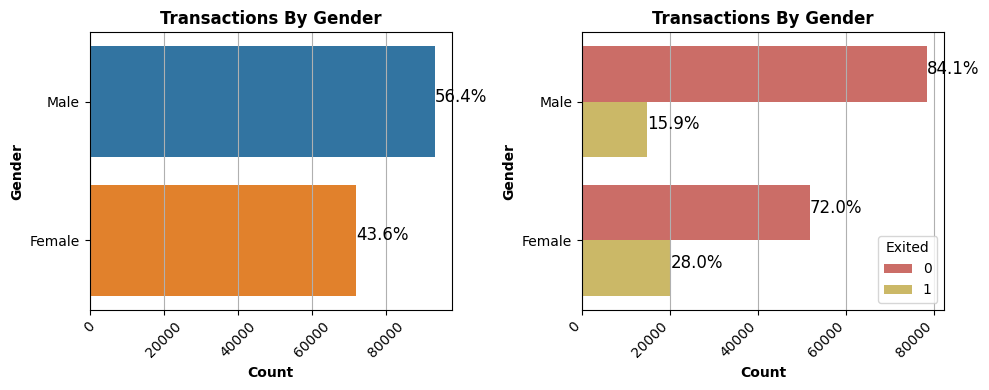

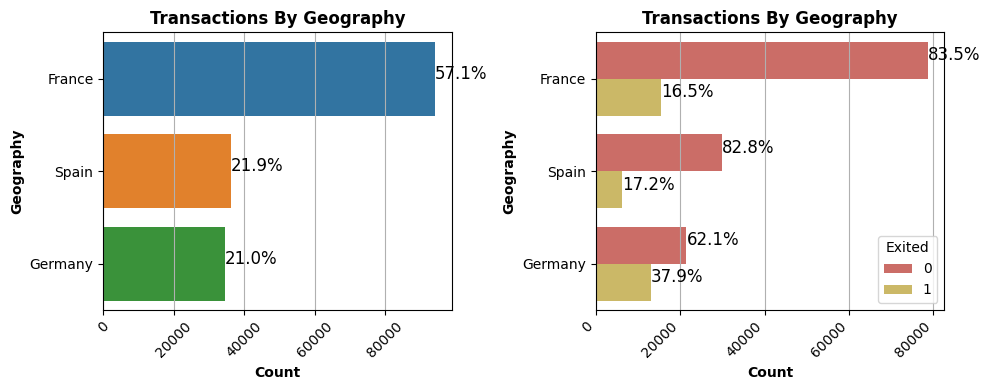

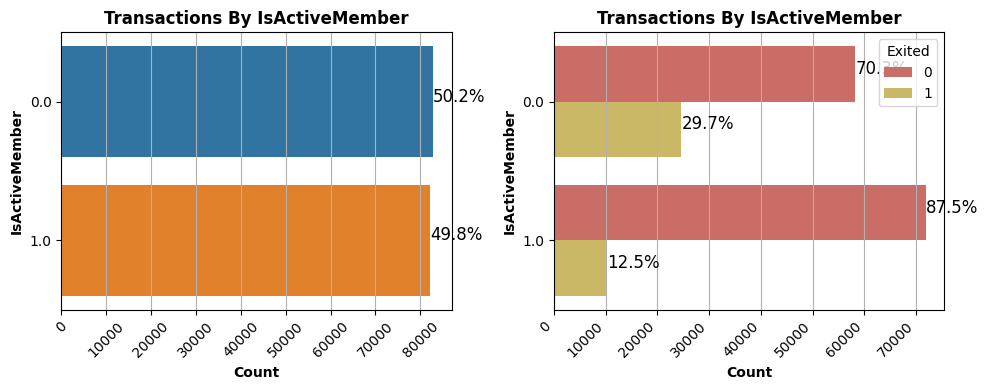

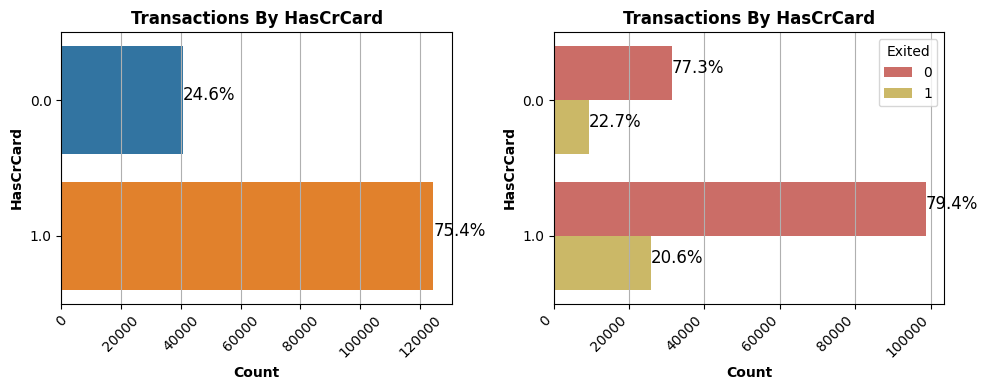

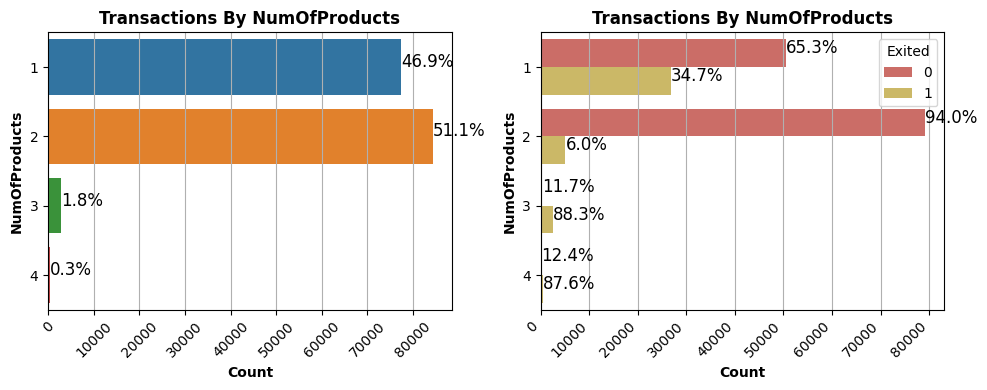

In [8]:
def plot_cat_feature(df, feat_cat, hue_cat):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
    cmap = sns.color_palette("hls", 8)
    
    # Main bar plot
    sns.countplot(data=df, y=feat_cat, ax=axs[0])
    axs[0].set_title(f'Transactions By {feat_cat}', weight='bold')
    axs[0].grid(axis='x')
    axs[0].set_ylabel(feat_cat, weight='bold')
    axs[0].set_xlabel('Count', weight='bold')

    # Bar plot with hue
    sns.countplot(data=df, y=feat_cat, hue=hue_cat, ax=axs[1], palette=cmap)
    axs[1].set_title(f'Transactions By {feat_cat}', weight='bold')
    axs[1].grid(axis='x')
    axs[1].set_ylabel(feat_cat, weight='bold')
    axs[1].set_xlabel('Count', weight='bold')
    
    # Rotate labels
    for i in [0, 1]:
        for label in axs[i].get_xticklabels():
            label.set_rotation(45)

    # Add annotations
    cat_count = df[feat_cat].nunique()
    hue_count = df[hue_cat].nunique()
    annotate_bars_horizontal(axs[0], cat_count)
    annotate_bars_horizontal_hue(axs[1], cat_count, hue_count)

    fig.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
plot_cat_feature(df, 'Gender', 'Exited')
plot_cat_feature(df, 'Geography', 'Exited')
plot_cat_feature(df, 'IsActiveMember', 'Exited')
plot_cat_feature(df, 'HasCrCard', 'Exited')
plot_cat_feature(df, 'NumOfProducts', 'Exited')

In [9]:
feats_num = ['CreditScore','Age','Tenure','Balance','EstimatedSalary', 'NumOfProducts']
df[feats_num].describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,112574.822734,1.554455
std,80.103340,8.867205,2.806159,62817.663278,50292.865585,0.547154
min,350.000000,18.000000,0.000000,0.000000,11.580000,1.000000
25%,597.000000,32.000000,3.000000,0.000000,74637.570000,1.000000
50%,659.000000,37.000000,5.000000,0.000000,117948.000000,2.000000
75%,710.000000,42.000000,7.000000,119939.517500,155152.467500,2.000000
max,850.000000,92.000000,10.000000,250898.090000,199992.480000,4.000000


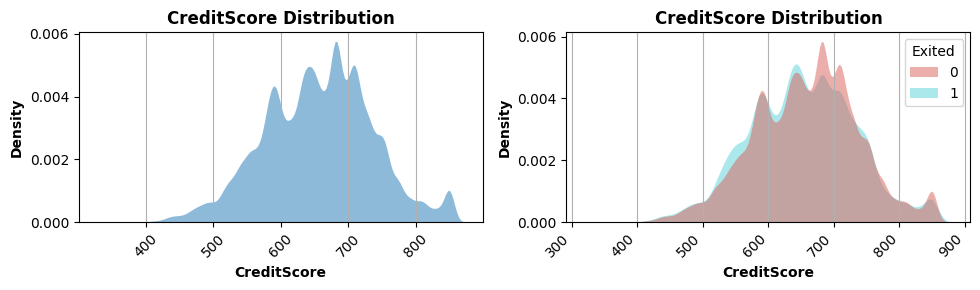

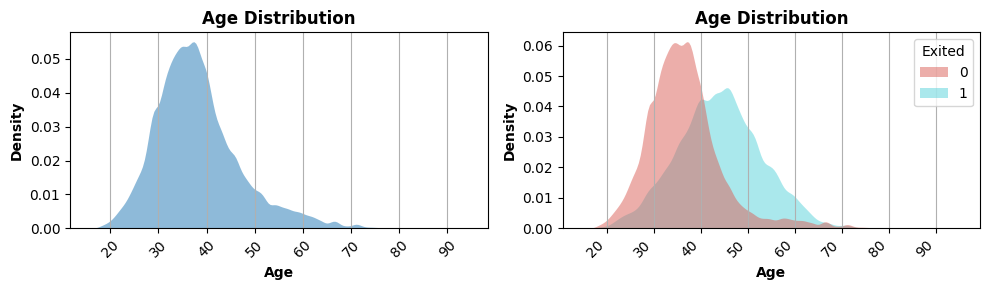

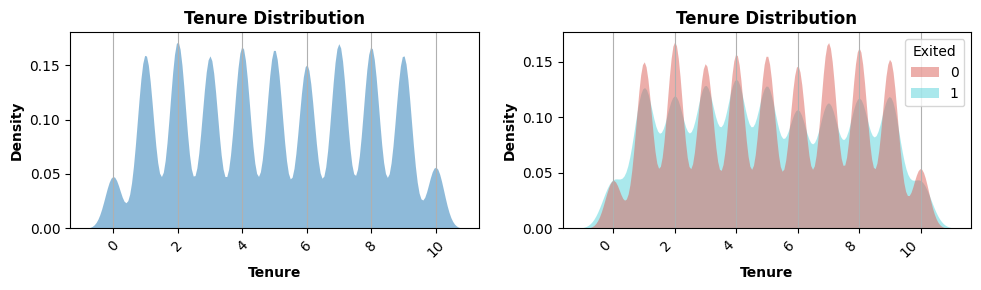

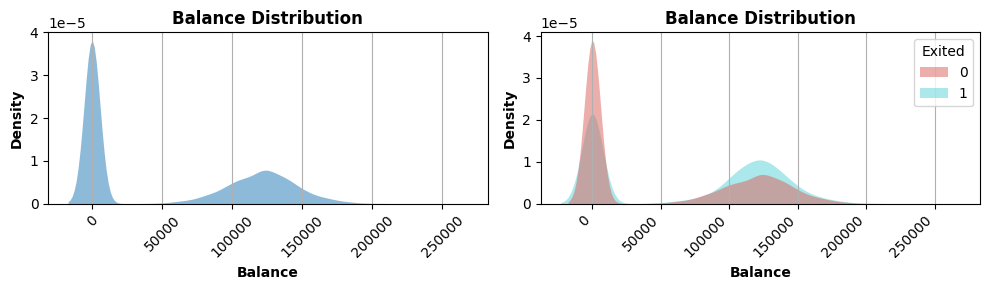

In [10]:
def plot_kdes(df, main_feat, hue_feat):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))   
    cmap = sns.color_palette("hls", 2)
    
    sns.kdeplot(data=df, x=main_feat, fill=True, common_norm=False, alpha=.5, linewidth=0, ax=axs[0])
    axs[0].set_title(f'{main_feat} Distribution', weight='bold')
    axs[0].set_xlabel(main_feat, weight='bold')
    axs[0].set_ylabel('Density', weight='bold')   
    axs[0].grid(axis='x')

    
    sns.kdeplot(data=df, x=main_feat, hue=hue_feat, fill=True, common_norm=False, palette=cmap, alpha=.5, linewidth=0, ax=axs[1])
    axs[1].set_title(f'{main_feat} Distribution', weight='bold')
    axs[1].set_xlabel(main_feat, weight='bold')
    axs[1].set_ylabel('Density', weight='bold')
    axs[1].grid(axis='x')

    
    # Rotate labels
    for i in [0, 1]:
        for label in axs[i].get_xticklabels():
            label.set_rotation(45)

    fig.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
plot_kdes(df, 'CreditScore', 'Exited')
plot_kdes(df, 'Age', 'Exited')
plot_kdes(df, 'Tenure', 'Exited')
plot_kdes(df, 'Balance', 'Exited')

Old memebers are more prominent in exiting.

#### Heat Map

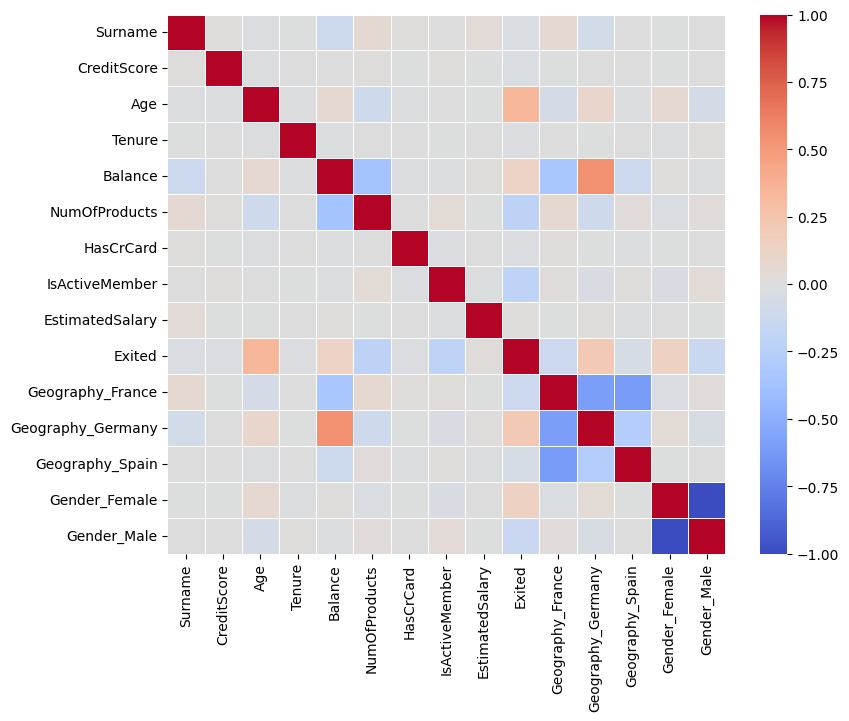

In [11]:
def plot_correlation(df):
    dff = df.drop(['id','CustomerId'], axis=1)

    dff = label_encode(dff, ['Surname'])
    dff = one_hot_encode(dff, ['Geography', 'Gender'])
    corr = dff.select_dtypes('number').corr()
    
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    fig, axs = plt.subplots(figsize=(9,7))
    sns.heatmap(corr, cmap=cmap,vmin=-1, vmax=1, linewidth=0.5)
    plt.show()
plot_correlation(df)

### Training & Prediction

Here, we're embarking on the creation of an ensemble model.
- Our ensemble comprises LGB, XGB, and Random Forest, chosen for their widespread popularity. Hyperparameter tuning is typically overlooked in my approach, as I value simple solutions that yield satisfactory outcomes.
- Nominal features like geography and gender require encoding into numerical formats, as most model packages accept only numerical data.
- Numerical data, such as credit score, age, and tenure, must undergo scaling due to the substantial variations in their original ranges. For instance, age typically spans from 0 to 100, while salaries can range from 0 to millions of dollars.
- To streamline our dataset, we discard the 'id' and 'customer id' columns, as these are mere identifiers. Although retaining 'Surname' for modeling is an option, I often find this feature intricate to handle, and it doesn't exhibit a robust correlation with bank churn.

In [12]:
df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')

def prepare_data(df):
    """Method to encode and scale data."""
    dff = df.drop(['id','CustomerId', 'Surname'], axis=1)

    dff = one_hot_encode(dff, ['Geography', 'Gender'])

    dff = scale_data(dff, ['CreditScore','Age','Tenure','Balance','EstimatedSalary'])
    return dff

def prepare_training_set(df, result_column):
    """Method to split data into training and validation sets."""
    dff = prepare_data(df)
    
    y = dff[result_column]
    x = dff.drop([result_column], axis=1)    
    
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1337)
    return x_train, x_val, y_train, y_val

def build_voting_model(df, result_column):
    """Method to build the voting classifier model. Returns the model."""
    x_train, x_val, y_train, y_val = prepare_training_set(df, result_column)
    
    # Instantiate classifier objects
    lgbc = lgb.LGBMClassifier()
    xgbc = xgb.XGBClassifier()
    rfc = RandomForestClassifier()

    # Fit data for each classifier
    lgbc.fit(x_train, y_train)
    xgbc.fit(x_train, y_train)
    rfc.fit(x_train, y_train)
       
    # Set up voting model for all the classifiers and fit
    voters = [('lgbc', lgbc), ('xgbc', xgbc), ('rfc', rfc)]
    vc = VotingClassifier(estimators=voters, voting='soft')
    vc.fit(x_train, y_train)
    
    # Predict
    lgbc_pred = lgbc.predict(x_val)
    xgbc_pred = xgbc.predict(x_val)
    rfc_pred = rfc.predict(x_val)
    vc_pred = vc.predict(x_val)
    
    # Check prediction accuracy
    lgbc_acc = accuracy_score(y_val, lgbc_pred)
    xgbc_acc = accuracy_score(y_val, xgbc_pred)
    rfc_acc = accuracy_score(y_val, rfc_pred)
    vc_acc = accuracy_score(y_val, vc_pred)
    print(f"LGB Classifier accuracy: {lgbc_acc:.6f}")
    print(f"XGB Classifier accuracy: {xgbc_acc:.6f}")
    print(f"RF Classifier accuracy: {rfc_acc:.6f}")
    print(f"Voting Classifier accuracy: {vc_acc:.6f}")    
    
    return vc

In [13]:
"""Prediction"""

# Train the model
vc = build_voting_model(df, 'Exited')

# Use the model to predict the test set

df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
probs = vc.predict_proba(prepare_data(df_test)) 
pfail = probs[:,1] 

LGB Classifier accuracy: 0.868573
XGB Classifier accuracy: 0.867119
RF Classifier accuracy: 0.862181
Voting Classifier accuracy: 0.868210


In [14]:
df_mysub = pd.DataFrame()
df_mysub['id'] = df_test['id']
df_mysub['Exited'] = pfail
df_mysub.to_csv('submission_of_competition.csv',index=False)
df_mysub.head()

,id,Exited
0,165034,0.028968
1,165035,0.881648
2,165036,0.017016
3,165037,0.259033
4,165038,0.313644
